In [31]:
# IBL Brain-wide Map Dataset Download 
%load_ext autoreload
%autoreload 2

import sys
import os
from one.api import ONE
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

# Test connection first
print("Setting up ONE API connection...")
try:
    from one.api import ONE
    
    # Setup ONE API
    ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
    one = ONE(password='international', silent=True)
    # Test a simple query to verify connection
    from brainwidemap import bwm_query
    df_test = bwm_query(one)
    
except Exception as e:
    print(f"Error setting up ONE API: {e}")
    print("Please check your internet connection and try again")
    raise

# Import the main functions
try:
    from dmn_bwm import get_all_PETHs, stack_concat
except Exception as e:
    print(f"Error importing dmn_bwm: {e}")
    raise

print("\n" + "="*50)
print("STARTING DATA DOWNLOAD")
print("="*50)

# Start with a smaller subset for testing (first 3 insertions)
n = 3
print(f"Testing with first {n} insertions...")
try:
    # Get first 3 insertions for testing (reduced from 10 for faster testing)
    df_subset = df_test.head(n)
    eids_subset = df_subset[['eid', 'probe_name', 'pid']].values
    
    print(f"About to process {len(eids_subset)} probe insertions:")
    for i, (eid, probe, pid) in enumerate(eids_subset):
        print(f"  {i+1}. EID: {eid}, Probe: {probe}, PID: {pid}")
    
    # get_all_PETHs(eids_plus=eids_subset, vers='concat')
    get_all_PETHs(eids_plus=eids_subset, vers='concat',n_splits=2,replace=False)
    
    print("\n" + "="*50)
    print("TEST SUCCESSFUL! Ready for full download.")
    print("="*50)
    print("To download all data, uncomment the line below and run:")
    print("# get_all_PETHs()  # This will download ALL ~700 probe insertions")
    print("WARNING: Full download will require significant disk space!")
    
except Exception as e:
    print(f"Error during download: {e}")
    import traceback
    traceback.print_exc()

print("\nTo proceed with concatenation after download, run:")
print("stack_concat(ephys=False)")


2025-09-02 13:08:50,466 [INFO] No newer cache available
Connected to IBL database successfully
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting up ONE API connection...
2025-09-02 13:08:52,255 [INFO] No newer cache available
Loading bwm_query results from fixtures/2023_12_bwm_release.csv

STARTING DATA DOWNLOAD
Testing with first 3 insertions...
About to process 3 probe insertions:
  1. EID: 6713a4a7-faed-4df2-acab-ee4e63326f8d, Probe: probe00, PID: 56f2a378-78d2-4132-b3c8-8c1ba82be598
  2. EID: 56956777-dca5-468c-87cb-78150432cc57, Probe: probe01, PID: 47be9ae4-290f-46ab-b047-952bc3a1a509
  3. EID: 56956777-dca5-468c-87cb-78150432cc57, Probe: probe00, PID: 6be21156-33b0-4f70-9a0f-65b3e3cd6d4a
Processing 3 insertions
eid 6713a4a7-faed-4df2-acab-ee4e63326f8d
Successfully loaded 565 trials for 6713a4a7-faed-4df2-acab-ee4e63326f8d
1 of 3 ok
12.888934959017206 sec
eid 56956777-dca5-468c-87cb-78150432cc57
Successfully loaded 425 trials for 5695

In [ ]:
get_all_PETHs()

In [26]:
%pdb

Automatic pdb calling has been turned ON


In [39]:
stack_concat(ephys=False,get_concat=False,n_splits=2)

combining 3 insertions for version concat
Loading bwm_query results from fixtures/2023_12_bwm_release.csv
3 insertions combined
339 good cells stacked before ephys
embedding rastermap on concat...
2025-09-02 13:24:48,672 [INFO] normalizing data across axis=1
2025-09-02 13:24:48,681 [INFO] projecting out mean along axis=0
2025-09-02 13:24:48,688 [INFO] data normalized, 0.02sec
2025-09-02 13:24:48,689 [INFO] sorting activity: 678 valid samples by 2496 timepoints
2025-09-02 13:24:49,395 [INFO] n_PCs = 200 computed, 0.72sec
2025-09-02 13:24:49,621 [INFO] 89 clusters computed, time 0.95sec
2025-09-02 13:24:55,803 [INFO] clusters sorted, time 7.13sec
2025-09-02 13:24:55,867 [INFO] clusters upsampled, time 7.20sec
2025-09-02 13:24:55,885 [INFO] rastermap complete, time 7.21sec
embedding umap on concat...
embedding pca on concat...
339 cells in eventually with 2 splits
> /Users/mitchellostrow/Desktop/Projects/playingaround/ibl_data/bwm_download/bwm_dmn/dmn_bwm.py(1617)stack_concat()
   1616 
-

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


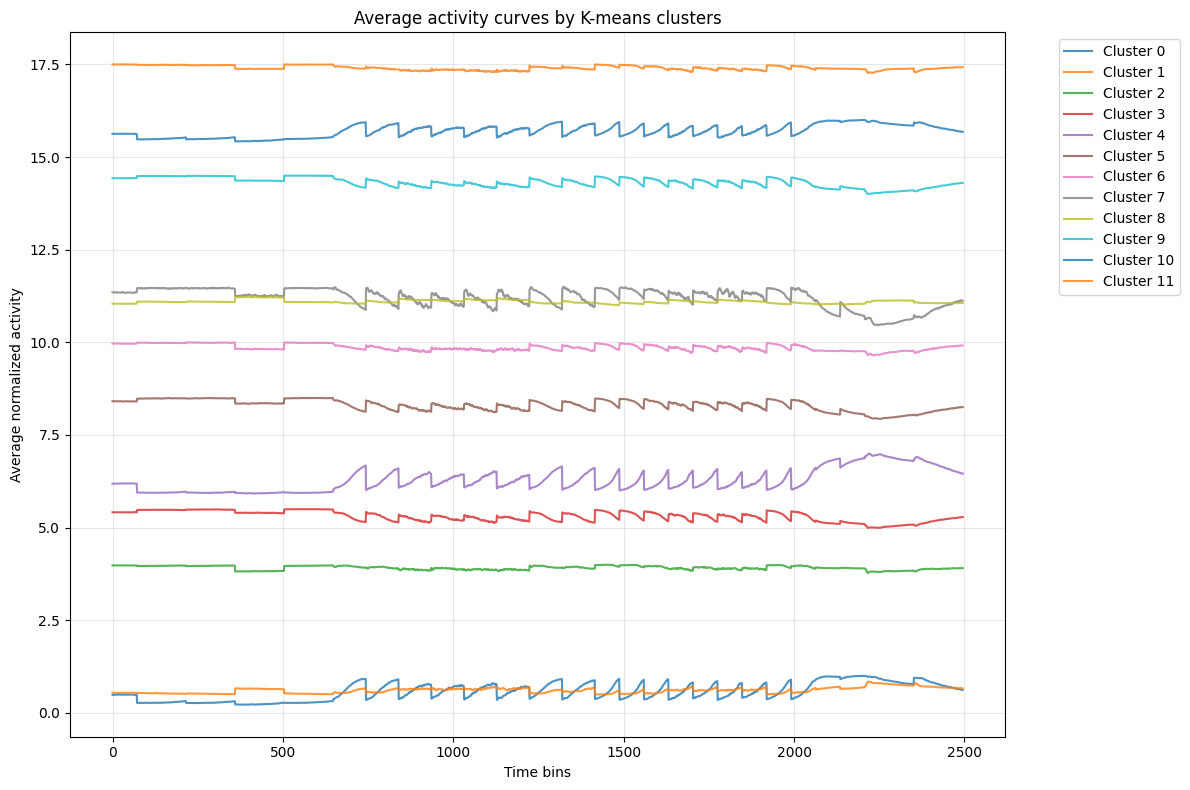

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

pth_dmn = Path(one.cache_dir, 'dmn', 'res')
datapath = Path(pth_dmn, f'concat_ephysFalse.npy')
data = np.load(datapath, allow_pickle=True).flat[0]
fig_path = "paper_figures"

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12,random_state=2025)
kmeans.fit(data['concat_z'])
labels = kmeans.labels_

# Calculate average activity for each cluster
unique_labels = np.unique(labels)
cluster_averages = []

for label in unique_labels:
    mask = labels == label
    avg_activity = np.mean(data['concat_z'][mask], axis=0)
    cluster_averages.append(avg_activity)

# Plot the average curves
plt.figure(figsize=(12, 8))
for i, avg_curve in enumerate(cluster_averages):
    avg_curve /= np.max(np.abs(avg_curve))
    plt.plot(avg_curve + 1.5*i, label=f'Cluster {unique_labels[i]}', alpha=0.8)

plt.xlabel('Time bins')
plt.ylabel('Average normalized activity')
plt.title('Average activity curves by K-means clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [9]:
import numpy as np
#load and make sure the data works
pth_dmn = Path(one.cache_dir, 'dmn', 'res')
datapath = Path(pth_dmn, f'concat_ephysFalse.npy')
data = np.load(datapath, allow_pickle=True).flat[0]
print(data.keys())
data['pca_z'].shape,data['umap_z'].shape, data['concat_z'].shape

dict_keys(['ids', 'xyz', 'uuids', 'pid', 'axial_um', 'lateral_um', 'channels', 'len', 'fr', 'concat_z', 'isort', 'umap_z', 'pca_z'])


((734, 2), (734, 2), (734, 2496))

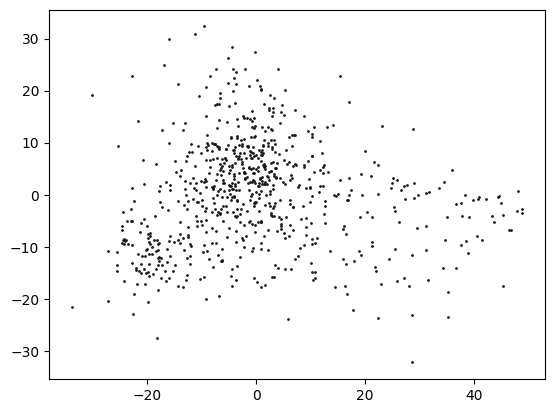

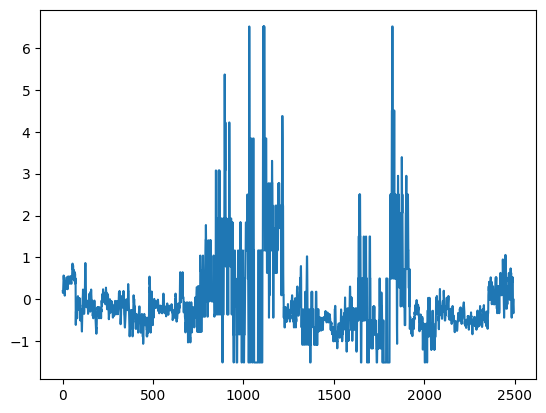

In [10]:
import matplotlib.pyplot as plt
plt.scatter(data['pca_z'][:,0],data['pca_z'][:,1],s=1,c='k')
plt.show()

plt.plot(data['concat_z'][0])